<a href="https://colab.research.google.com/github/BeyzaSalmann/CNN_siniflandirma/blob/main/model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Adınız:** Beyza

**Soyadınız:** Salman

**Okul Numaranız:** 2212721049

**GitHub Repo Bağlantısı:** https://github.com/BeyzaSalmann/CNN_siniflandirma

# 1. Proje Yaklaşımı: Transfer Learning ile Sınıflandırma (Model 1)

**Proje Özeti:**
Bu not defterinde, UNO oyun kartları üzerindeki **"Engel" (Skip)** ve **"Yön Değiştir"** sembollerini sınıflandırmak için Derin Öğrenme literatüründe başarısı kanıtlanmış **Transfer Learning (Transfer Öğrenme)** yöntemi kullanılmıştır.

**Kullanılan Mimari: VGG16**
Veri setimizde 2 adet sınıf kullanılmıştır bunlar sınıf1 ve sınıf2'dir. Modeli sıfırdan eğitmek yerine **ImageNet** veri seti üzerinde milyonlarca görüntü ile eğitilmiş **VGG16** modelinin ağırlıkları (`weights='imagenet'`) kullanılmıştır.

**Uygulanan Yöntem:**
* **Öznitelik Çıkarımı:** VGG16'nın evrişim katmanları dondurulmuş (frozen) ve modelin görsel algılama yeteneği korunmuştur.
* **Sınıflandırma:** Modelin çıkışına, projemize özgü (2 sınıflı) yeni Tam Bağlantılı (Fully Connected) katmanlar eklenerek eğitim gerçekleştirilmiştir.

**Amaç ve Beklenti:**
Bu modelin amacı, az veriyle maksimum doğruluğa ulaşmak ve projenin "State-of-the-Art" (En İyi) performans skorunu belirlemektir. Beklentimiz, bu modelin sıfırdan eğitilen Model 2'ye göre çok daha yüksek bir başarı göstermesidir.

### 1. Hazırlık: Kütüphaneler ve Veri Setinin Ortama Aktarılması

Bu adımda, derin öğrenme modelimizi oluşturmak ve eğitmek için gerekli olan temel kütüphaneleri (`TensorFlow`, `Keras`, `Matplotlib`, `Numpy`) çalışma ortamına dahil ediyoruz.

Ayrıca, Google Drive üzerinde `.zip` formatında saklanan özgün veri setimizi Colab'in geçici hafızasına çıkarıyoruz. Bu işlem, Drive üzerinden okuma yapmaya kıyasla eğitimin çok daha hızlı gerçekleşmesini sağlar.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

zip_path = "/content/drive/MyDrive/OdevProjesi/veri_seti.zip"
extract_path = "/content/dataset"

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Veri seti başarıyla çıkarıldı.")
else:
    print("Hata: Zip dosyası belirtilen konumda bulunamadı.")


base_dir = os.path.join(extract_path, "veri_seti")

Veri seti başarıyla çıkarıldı.


### 2. Veri Ön İşleme ve Normalizasyon

Modelin görüntüleri daha verimli işleyebilmesi için ham veriler üzerinde şu işlemler uygulanmıştır:
1.  **Yeniden Boyutlandırma:** Tüm görüntüler, VGG16 mimarisine ve donanım kısıtlarına uygun olarak **128x128 piksel** boyutuna getirilmiştir.
2.  **Normalizasyon (Rescaling):** 0-255 arasındaki RGB piksel değerleri, **0-1 aralığına** sıkıştırılarak matematiksel işlem yükü azaltılmıştır.
3.  **Veri Ayrımı (Split):** Modelin başarısını objektif ölçmek için veri seti **%80 Eğitim** ve **%20 Doğrulama (Validation)** olarak ikiye ayrılmıştır.

In [ ]:
# Hiperparametrelerin belirlenmesi
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001


# Veri seti %80 Eğitim, %20 Doğrulama (Validation/Test) olarak ayrılmıştır.
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Eğitim verisinin yüklenmesi
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Doğrulama (Test) verisinin yüklenmesi
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Sınıf etiketlerinin kontrolü
print(f"Sınıf Etiketleri: {train_generator.class_indices}")

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Sınıf Etiketleri: {'engel': 0, 'yon_degistir': 1}


### 3. Model Mimarisi: Transfer Learning (VGG16)

Veri setimizdeki görüntü sayısı (sınıf başına ~50-60 adet) derin bir ağı sıfırdan eğitmek için kısıtlıdır. Bu nedenle, literatürde başarısı kanıtlanmış **Transfer Learning (Transfer Öğrenme)** yöntemi tercih edilmiştir.

* **Temel Model:** ImageNet veri setindeki milyonlarca görüntüyle eğitilmiş **VGG16** modeli kullanılmıştır.
* **İnce Ayar (Fine-Tuning):** VGG16'nın önceden eğitilmiş ağırlıkları (`weights='imagenet'`) yüklenmiş ve evrişim katmanları dondurulmuştur (`include_top=False`). Böylece modelin "görme yeteneği" korunmuştur.
* **Sınıflandırıcı:** Modelin çıkışına, projemize özgü olan 2 sınıfı (Engel ve Yön Değiştir) ayırt edecek yeni Tam Bağlantılı (Dense) katmanlar eklenmiştir.

In [ ]:
# VGG16 modelinin ImageNet ağırlıkları ile yüklenmesi
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Temel modelin katmanlarının dondurulması (Freezing)
for layer in base_model.layers:
    layer.trainable = False

# Yeni sınıflandırma katmanlarının eklenmesi
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Aşırı öğrenmeyi engellemek için
model.add(Dense(2, activation='softmax')) # 2 Sınıf olduğu için çıkış katmanı 2 nöronludur


model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,610 (64.14 MB)

 Trainable params: 2,097,922 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 4. Modelin Eğitilmesi

Hazırlanan VGG16 tabanlı model, belirlenen hiperparametreler (Epoch sayısı, Batch Size, Learning Rate) ile eğitime tabi tutulmaktadır. Eğitim süresince modelin hem eğitim verisi üzerindeki başarısı (Accuracy) hem de doğrulama verisi üzerindeki başarısı (Val Accuracy) takip edilmektedir.

In [ ]:
# Eğitim
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 10s/step - accuracy: 0.6111 - loss: 0.9586 - val_accuracy: 0.6500 - val_loss: 0.6121
Epoch 2/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5938 - loss: 0.7783

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5938 - loss: 0.7783 - val_accuracy: 0.8000 - val_loss: 0.5588
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6875 - loss: 0.6127 - val_accuracy: 0.7500 - val_loss: 0.5434
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step - accuracy: 0.6250 - loss: 0.7624 - val_accuracy: 0.8500 - val_loss: 0.5078
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.8403 - loss: 0.4040 - val_accuracy: 0.8500 - val_loss: 0.4777
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6875 - loss: 0.4433 - val_accuracy: 0.7500 - val_loss: 0.4911
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.8194 - loss: 0.4217 - val_accuracy: 0.7500 - val_loss: 0.4904
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step - accuracy: 0.7812 - loss: 0.4309 - val_accuracy: 0.8000 - val_loss: 0.4702
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8958 - loss: 0.3455 - val_accuracy: 0.8000 - val_loss: 0.4350
Epoch 10/10
2/2 ━━━━━

### 5. Performans Analizi ve Sonuçlar

Eğitim tamamlandıktan sonra modelin başarımı grafiklerle görselleştirilmiştir:
* **Doğruluk Grafiği:** Modelin öğrenme istikrarını gösterir.
* **Kayıp (Loss) Grafiği:** Modelin hata oranının zamanla nasıl düştüğünü gösterir.

Aşağıdaki çıktıda, modelin hiç görmediği test verileri üzerindeki **Nihai Başarı Oranı** raporlanmıştır.

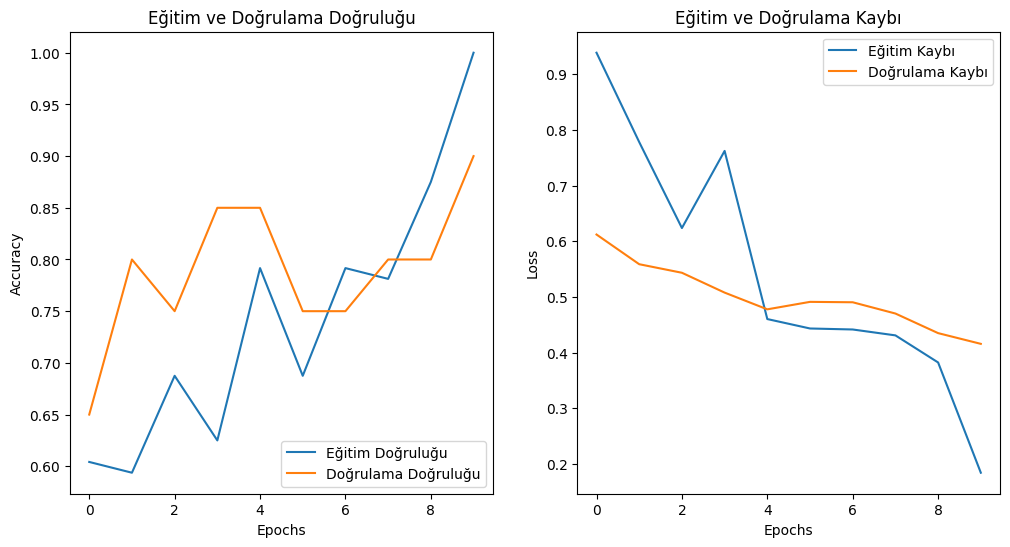

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step - accuracy: 0.9000 - loss: 0.4157

Model 1 - Test Seti Doğruluğu: %90.00
Model 1 - Test Seti Kaybı: 0.4157


In [ ]:
# Grafik çizimi
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Doğruluk (Accuracy) Grafiği
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
    plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
    plt.legend(loc='lower right')
    plt.title('Eğitim ve Doğrulama Doğruluğu')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Kayıp (Loss) Grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Eğitim Kaybı')
    plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
    plt.legend(loc='upper right')
    plt.title('Eğitim ve Doğrulama Kaybı')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()


plot_training_history(history)


val_loss, val_acc = model.evaluate(validation_generator)
print(f"\nModel 1 - Test Seti Doğruluğu: %{val_acc * 100:.2f}")
print(f"Model 1 - Test Seti Kaybı: {val_loss:.4f}")